In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error


DATA_PATH = "cleaned_balanced_dataset.csv"
TARGET = "Addiction_Level"
FEATURES = [
    "Sleep_Hours","Age","Daily_Usage_Hours","Academic_Performance",
    "Apps_Used_Daily","Time_on_Social_Media","Weekend_Usage_Hours",
    "Phone_Checks_Per_Day","Time_on_Gaming"
]
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV = 5


df = pd.read_csv(DATA_PATH)


X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


def evaluate_model(pipe, X_test, y_test, X_full, y_full, cv=CV):
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(pipe, X_full, y_full, cv=cv, scoring='r2')
    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2_test": r2,
        "CV_R2_mean": cv_scores.mean(),
        "CV_R2_std": cv_scores.std()
    }

models_and_grids = {
    "LinearRegression": {
        "estimator": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
    },
    "Ridge": {
        "estimator": Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))]),
        "param_grid": {
            "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
            "model__solver": ['auto']
        }
    },
    "Lasso": {
        "estimator": Pipeline([("scaler", StandardScaler()), ("model", Lasso(random_state=RANDOM_STATE, max_iter=10000))]),
        "param_grid": {
            "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]
        }
    },
    "ElasticNet": {
        "estimator": Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))]),
        "param_grid": {
            "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0],
            "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    },
    
}


results = []
for name, mg in models_and_grids.items():
    
    
    estimator = mg.get("estimator")
    param_grid = mg.get("param_grid", {}) 

    if param_grid and len(param_grid) > 0:
        gs = GridSearchCV(
            estimator, 
            param_grid, 
            scoring='neg_mean_squared_error', 
            cv=CV, 
            n_jobs=-1, 
            verbose=0
        )
        gs.fit(X_train, y_train)
        best_pipe = gs.best_estimator_
        best_params = gs.best_params_
    else:
        estimator.fit(X_train, y_train)
        best_pipe = estimator
        best_params = {}

    scores = evaluate_model(best_pipe, X_test, y_test, X, y, cv=CV)
    row = {
        "Model": name,
        "Best_Params": best_params,
        "RMSE": scores["RMSE"],
        "MAE": scores["MAE"],
        "R2_test": scores["R2_test"],
        "CV_R2_mean": scores["CV_R2_mean"],
        "CV_R2_std": scores["CV_R2_std"]
    }
    results.append(row)

results_df = pd.DataFrame(results).sort_values("RMSE")

results_df


,Model,Best_Params,RMSE,MAE,R2_test,CV_R2_mean,CV_R2_std
3,ElasticNet,"{'model__alpha': 0.001, 'model__l1_ratio': 0.9}",0.648592,0.405010,0.944315,0.954011,0.004366
2,Lasso,{'model__alpha': 0.001},0.648595,0.405010,0.944314,0.954011,0.004367
1,Ridge,"{'model__alpha': 1.0, 'model__solver': 'auto'}",0.648671,0.404389,0.944301,0.954007,0.004372
0,LinearRegression,{},0.648768,0.403966,0.944284,0.954007,0.004379


Top Features:
                Feature  Coefficient
2     Daily_Usage_Hours     0.867158
8        Time_on_Gaming     0.842280
5  Time_on_Social_Media     0.809817
0           Sleep_Hours    -0.444204
4       Apps_Used_Daily     0.172407
6   Weekend_Usage_Hours    -0.025055
7  Phone_Checks_Per_Day     0.018126
1                   Age     0.002400
3  Academic_Performance    -0.000020


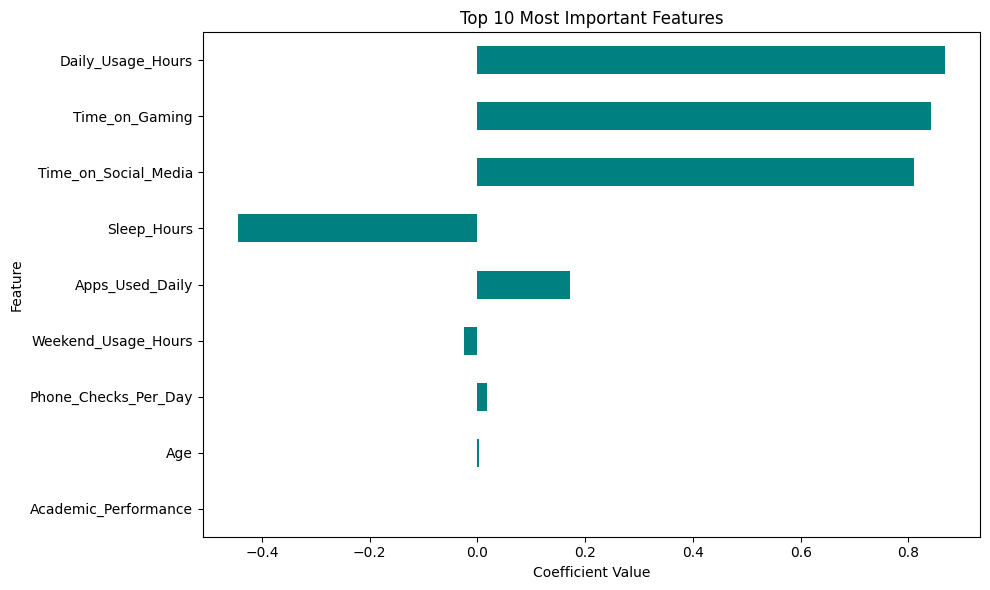

In [2]:

import matplotlib.pyplot as plt


best_elastic = ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=42)

best_elastic.fit(X_train, y_train)


coef = best_elastic.coef_
features = X_train.columns


coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coef
}).sort_values("Coefficient", key=abs, ascending=False)

print("Top Features:")
print(coef_df)


plt.figure(figsize=(10, 6))
coef_df.head(10).set_index("Feature")["Coefficient"].plot(kind="barh", color="teal")
plt.gca().invert_yaxis()
plt.title("Top 10 Most Important Features")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


In [3]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

mlflow.set_experiment("Addiction_Level_Regression")

models_and_grids = {
    "LinearRegression": {
        "estimator": Pipeline([
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ]),
        "param_grid": {}
    },
    "Ridge": {
        "estimator": Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge())
        ]),
        "param_grid": {"model__alpha": [0.01, 0.1, 1, 10]}
    },
    "Lasso": {
        "estimator": Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso(max_iter=5000))
        ]),
        "param_grid": {"model__alpha": [0.0001, 0.001, 0.01, 0.1]}
    },
    "ElasticNet": {
        "estimator": Pipeline([
            ('scaler', StandardScaler()),
            ('model', ElasticNet(max_iter=5000))
        ]),
        "param_grid": {
            "model__alpha": [0.0001, 0.001, 0.01, 0.1],
            "model__l1_ratio": [0.1, 0.5, 0.9]
        }
    }
}

for name, mg in models_and_grids.items():
    estimator = mg["estimator"]
    param_grid = mg["param_grid"]

    with mlflow.start_run(run_name=name):
        if param_grid:
            gs = GridSearchCV(estimator, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
            gs.fit(X_train, y_train)
            best_model = gs.best_estimator_
            mlflow.log_params(gs.best_params_)
        else:
            estimator.fit(X_train, y_train)
            best_model = estimator

        y_pred = best_model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

        
        signature = infer_signature(X_train, best_model.predict(X_train))
        input_example = X_train.iloc[:1]

        mlflow.sklearn.log_model(
            sk_model=best_model,
            name="model",                    
            input_example=input_example,
            signature=signature
        )


c:\Users\Admin\anaconda3\Anaconda\envs\myenv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


c:\Users\Admin\anaconda3\Anaconda\envs\myenv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


c:\Users\Admin\anaconda3\Anaconda\envs\myenv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


c:\Users\Admin\anaconda3\Anaconda\envs\myenv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [4]:
features = ['Sleep_Hours','Age','Daily_Usage_Hours', 'Academic_Performance','Apps_Used_Daily','Time_on_Social_Media','Weekend_Usage_Hours','Phone_Checks_Per_Day','Time_on_Gaming']
target = 'Addiction_Level'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=42)
model.fit(X_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=42)

In [5]:
import joblib

joblib.dump(model, 'addiction_model_v2.pkl')

['addiction_model_v2.pkl']